# STOR 566, Homework 3
### Instructor: Yao Li
### Keywords: LSTM, SST2
### Due date: Oct 02, 11:55pm
### **Submission Instruction**

- Please download this script and use it to answer the questions in the homework. 
- For submission, please include your code, code output and answers in the script and submit the ipynb file on sakai.
- Please don't modify existing cells. But you can add cells between the exercise statements.
- To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language. For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

### **References:**

- You can follow the setup instructions at [here](https://pytorch.org/get-started/locally/).
- A useful tutorial on learning pytorch by examples at [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).
- Check Pytorch optimization methods at [here](https://pytorch.org/docs/stable/optim.html).
- Check Torchtext tutorial at [here](https://pytorch.org/text/stable/tutorials/sst2_classification_non_distributed.html).


### **Evaluation Metrics of Classifiers:**

- Average Test Loss (based on the test set): 
    \begin{align}
	  \frac{1}{B}\sum_{b=1}^B {\text loss}_b
	  \end{align}
    
    - $B$: the total number of batches from the test set
    - loss$_b$: the loss of $b$-th batch
    - Note: loss$_b$=criteria(output, target), where criteria is the loss function you use.

- Testing accuracy: 
	\begin{align}
	\frac{1}{N}\sum_{i=1}^N {\bf 1}(\hat{y}_i=y_i)
	\end{align}	
    - $N$: the total number of samples in the testing set
    - $y_i$: true label of sample $i$
    - $\hat{y}_i$: predicted label by the model

## Problem 1 (100 points)

In this problem you will practice implementing LSTM on SST2 data set to do sentiment analysis (binary classification of positive vs. negative).

**Data.** You will use SST2 dataset. Pytorch/torchdata has provide a useful dataloader to automatically download and load the data into batches. In this homework, you need two class, positive and negative, for binary classification. Code of the data loader has been provided in the template. You can modify the data loading part to use different tokenizer.

In [1]:
'''
# You need package torchdata for this homework
# To avoid loading it every time, you can install torchdata to a path on google drive
import os
from google.colab import drive
drive.mount('/content/drive')
pkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS'
!pip install --target=$pkg_path torchdata

# Append the path to the sys path to load the pkg without re-installation
import sys
pkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS'
sys.path.append(pkg_path)
import torchdata
'''

"\n# You need package torchdata for this homework\n# To avoid loading it every time, you can install torchdata to a path on google drive\nimport os\nfrom google.colab import drive\ndrive.mount('/content/drive')\npkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS'\n!pip install --target=$pkg_path torchdata\n\n# Append the path to the sys path to load the pkg without re-installation\nimport sys\npkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS'\nsys.path.append(pkg_path)\nimport torchdata\n"

In [2]:
# Mount your drive
import os
import sys
#from google.colab import drive
#drive.mount('/content/drive')
pkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS' #Please specify the path where you installed torchdata
sys.path.append(pkg_path)

In [3]:
# Package Loading
# Feel free to add pakcages
import torchdata
import torch
import torch.nn as nn
import torchtext.transforms as T
import torchtext.functional as F
from torchtext.datasets import SST2
from torch.utils.data import DataLoader
from torch.hub import load_state_dict_from_url
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# Prepare data loader
# Feel free to modify the data loading process as needed
padding_idx = 1
bos_idx = 0
eos_idx = 2
batch_size = 16
max_seq_len = 256
# You can use other Tokenizer
xlmr_vocab_path = r"https://download.pytorch.org/models/text/xlmr.vocab.pt"
xlmr_spm_model_path = r"https://download.pytorch.org/models/text/xlmr.sentencepiece.bpe.model"
xmlr_vocab = load_state_dict_from_url(xlmr_vocab_path)

text_transform = T.Sequential(
    T.SentencePieceTokenizer(xlmr_spm_model_path),
    T.VocabTransform(xmlr_vocab),
    T.Truncate(max_seq_len - 2),
    T.AddToken(token=bos_idx, begin=True),
    T.AddToken(token=eos_idx, begin=False),
)

train_datapipe = SST2(split="train")
test_datapipe = SST2(split="dev")

def apply_transform(x):
    return text_transform(x[0]), x[1]

train_datapipe = train_datapipe.map(apply_transform)
train_datapipe = train_datapipe.batch(batch_size)
train_datapipe = train_datapipe.rows2columnar(["token_ids", "target"])
train_dataloader = DataLoader(train_datapipe, batch_size=None)

test_datapipe = test_datapipe.map(apply_transform)
test_datapipe = test_datapipe.batch(batch_size)
test_datapipe = test_datapipe.rows2columnar(["token_ids", "target"])
test_dataloader = DataLoader(test_datapipe, batch_size=None)

### **Problem Description.** Implement **LSTM** with Pytorch to do binary classification.

### (a) (15 points) Print the model architecture.

In [5]:
class lstm(nn.Module):

	def __init__(self, hidden_dim,embediing ,voc = 250003):
		super(lstm, self).__init__()
		self.hidden_dim = hidden_dim
		self.LSTM_layers = 1
		self.input_size = voc 
		self.embedding_value = embediing
		self.embedding = nn.Embedding(self.input_size, embediing)
		self.lstm = nn.LSTM(input_size=self.embedding_value, hidden_size=self.hidden_dim, num_layers=self.LSTM_layers, batch_first=True)
		self.fc1 = nn.Linear(in_features=self.hidden_dim, out_features=2)
		
	def forward(self, x):
	
		h = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim))
		c = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim))
		
		torch.nn.init.xavier_normal_(h)
		torch.nn.init.xavier_normal_(c)

		out = self.embedding(x)
		out, (hidden, cell) = self.lstm(out, (h,c))
		return self.fc1(out[:,-1])

In [6]:
model = lstm(64,128)
print(model)

lstm(
  (embedding): Embedding(250003, 128)
  (lstm): LSTM(128, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=2, bias=True)
)


### (b) (10 points) Report the hyper-parameters (number of epochs, learning rate, momentum, weight_decay etc).

Answer: learning rate: 0.1, epoch: 10, momentum:0.9
hidden: 32, embeding:32

### (c) (60 points) Report the **Average Test Loss** after every training epoch by generating Average Test Loss vs. Epoch plot. Please report at least **10** epochs. Note that **Average Test Loss** is based on the test set.


In [7]:
import torchtext.functional as F
from torch.optim import SGD
learning_rate = 0.1
optim = SGD(model.parameters(), lr=learning_rate)
criteria = nn.CrossEntropyLoss()


def train_step(input, target):
    
    output = model(input)
    loss = criteria(output, target)
    
    optim.zero_grad()
    loss.backward()
    optim.step()


def eval_step(input, target):
    output = model(input)

    loss = criteria(output, target).item()
    return float(loss), (output.argmax(1) == target).type(torch.float).sum().item()


def evaluate():
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    counter = 0
    with torch.no_grad():
        for batch in test_dataloader:
            input = F.to_tensor(batch["token_ids"], padding_value=padding_idx)
            target = torch.tensor(batch["target"])

            loss, predictions = eval_step(input, target)
            total_loss += loss
            correct_predictions += predictions
            total_predictions += len(target)
            counter += 1

    return total_loss / counter, correct_predictions / total_predictions

In [8]:
lost_list = []
for e in range(10):
    for batch in train_dataloader:
        input = F.to_tensor(batch["token_ids"], padding_value=padding_idx)
        target = torch.tensor(batch["target"])
        #target = torch.reshape(target,(len(target),1))
        train_step(input, target)
    loss, accuracy = evaluate()
    lost_list.append(loss)
    print("Epoch = [{}], loss = [{}], accuracy = [{}]".format(e, loss, accuracy))

Epoch = [0], loss = [0.7020275657827204], accuracy = [0.5091743119266054]
Epoch = [1], loss = [0.6076282273639332], accuracy = [0.6754587155963303]
Epoch = [2], loss = [0.5346441355618563], accuracy = [0.7396788990825688]
Epoch = [3], loss = [0.5395321501926942], accuracy = [0.7660550458715596]
Epoch = [4], loss = [0.5563089156692679], accuracy = [0.7717889908256881]
Epoch = [5], loss = [0.555206329443238], accuracy = [0.7889908256880734]
Epoch = [6], loss = [0.6734230584718964], accuracy = [0.7740825688073395]
Epoch = [7], loss = [0.6193433467637409], accuracy = [0.7855504587155964]
Epoch = [8], loss = [0.7021702525290576], accuracy = [0.7775229357798165]
Epoch = [9], loss = [0.7293656604533846], accuracy = [0.7809633027522935]


### (c) (60 points) Report the **Average Test Loss** after every training epoch by generating Average Test Loss vs. Epoch plot. Please report at least **10** epochs. Note that **Average Test Loss** is based on the test set.

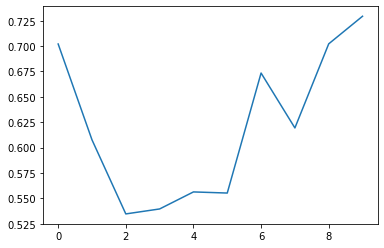

In [11]:
import matplotlib.pyplot as plt
x_axis = [x for x in range(10)]
plt.plot(x_axis, lost_list)

### (d) (15 points) Report the final testing accuracy of trained model.

In [12]:
print(accuracy)

0.7809633027522935


Answer: Hence, the final testing accuracy is 0.7809633027522935.